################################################################################################################
# PREDICTING DIABETES 30-DAY READMISSIONS #
################################################################################################################

## DESCRIPTION :: Diabetes 130-US hospitals for years 1999-2008 Data Set 

## SOURCE :: UC IRVINE MACHINE LEARNING REPOSITORY

* https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 

## WHY I'M INTERESTED / MY DOMAIN EXPERTISE

With ObamaCare we have more people getting care than before.  This is great, but it is forcing the health system to change its payment model from 'fee for service' to 'fee for performance'.  A good example of this is that hospitals used to get paid when you were in the hospital for a heart attack.  But the hospital would not get paid while you recovered.  The new paradigm puts more risk on the hospital's side by punishing hospitals if a patient is re-admitted within certain time periods for problems that are deemed preventable.  

- My group at work is trying to deal with this change from a structural way.
- My role is to help patients be better able to self-manage their chronic conditions so they need less health-system utilization.
- I work specifically with patients with diabetes and specifically around keeping them out of the ED and hospital.
- When a patient is in the hospital, they incur lots of other risk factors from deconditioning, hospital-acquired infections, and potential errors...on top of that, all of these tests are expensive.

## WHAT I'M HOPING TO GAIN FROM THIS
- What factors predict a readmission within 30-days; causing a costly punishment? 
- What factors predict a readmission after 30 days (that's not currently punishable, but may be preventable)
- What factors lead to no readmission?  
- Can we find any top and bottom performers?

> # IMPORT PACKAGES

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

> # IMPORT DATA

In [127]:
data = pd.read_csv('http://localhost:8888/files/PROJECT%20-%20BBURKART/DATA/diabetes.csv')
data.shape

(101766, 50)

### overview

In [128]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

### first look

In [129]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


> # CLEANING

In [130]:
# ------------------------------------------------------------------------------------
# CONVENTIONALIZE COLUMN NAMES
# ------------------------------------------------------------------------------------
data.columns = [each.replace(' ','_').lower() for each in data.columns]
data.columns = [each.replace('-','_').lower() for each in data.columns]

data = data.rename(columns = {'admission_type_id' : 'admission_type',
                              'discharge_disposition_id' : 'discharge_disposition',
                              'admission_source_id' : 'admission_source',
                              'time_in_hospital' : 'length_of_stay',
                              'payer_code' : 'payor_code',
                              'medical_specialty' : 'referring_specialty', 
                              'num_lab_procedures' : 'number_labs',
                              'num_procedures' : 'number_procedures', 
                              'num_medications' : 'number_meds',
                              'number_diagnoses' : 'total_number_diag', 
                              'max_glu_serum' : 'max_blood_glucose',
                              'a1cresult' : 'a1c', 
                              'diabetesmed' : 'on_diabetes_meds',
                              'readmitted' : 'readmission_category'})

# ------------------------------------------------------------------------------------
# DROP PATIENT-SPECIFIC INFORMATION, SINCE IT WON'T HELP WITH ANY PREDICTION OR CLASSIFICATION
# ------------------------------------------------------------------------------------

data = data.drop('encounter_id', 1)
data = data.drop('patient_nbr', 1)


# ------------------------------------------------------------------------------------
# FIX COLUMNS WITH RANGES TO ACTUALLY REFLECT RANGE VALUES
# ------------------------------------------------------------------------------------

# --- age
data.age = data.age.apply(lambda x: x.split('[')[1])
data.age = data.age.apply(lambda x: x.split(')')[0])


# --- weight
to_replace_weight = {
    '?' : '?',
    '[0-25)' : '0 to 25',
    '[25-50)': '25 to 50',
    '[50-75)': '50 to 75',
    '[75-100)': '75 to 100',
    '[100-125)': '100 to 125',
    '[125-150)': '125 to 150',
    '[150-175)': '150 to 175',
    '[175-200)': '175 to 200',
    '>200': 'over 200'}
data['weight'] = data['weight'].apply(lambda x:to_replace_weight[x])


# ------------------------------------------------------------------------------------
# FIX COLUMNS WITH ID CODES TO ACTUALLY REFLECT VALUES, SINCE THEY'RE CATEGORICAL
# ------------------------------------------------------------------------------------

# --- admission_type
to_replace_admission_type = {
    1 : 'emergency',
    2 : 'urgent',
    3 : 'elective',
    4 : 'newborn',
    5 : 'not available',
    6 : 'NULL',
    7 : 'trauma center',
    8 : 'not mapped'} 
data['admission_type'] = data['admission_type'].apply(lambda x:to_replace_admission_type[x])


# --- discharge_disposition
to_replace_discharge_disposition = {
    1 : 'home',
    2 : 'short term hospital',
    3 : 'SNF',
    4 : 'ICF',
    5 : 'inpatient care institution',
    6 : 'home with home health service',
    7 : 'Left AMA',
    8 : 'home under care of home IV provider',
    9 : 'admitted to this hospital',
    10 : 'neonate to another neonate hospital',
    11 : 'expired',
    12 : 'still patient or expected to return for outpatient',
    13 : 'hospice at home',
    14 : 'hospice at medical facility',
    15 : 'this institution for medicare approved swing bed',
    16 : 'another institution for outpatient services',
    17 : 'this institution for outpatient services',
    18 : 'NULL',
    19 : 'expired at home. Medicaid only, hospice',
    20 : 'expired at medical facility. Medicaid only, hospice',
    21 : 'expired at unknown place. Medicaid only, hospice',
    22 : 'rehab facility',
    23 : 'long term care hospital',
    24 : 'SNF under medicaid, but not medicare',
    25 : 'not mapped',
    26 : 'another health care facility, undefined',
    27 : 'federal health care facility',
    28 : 'psychiatric hospital',
    29 : 'critical care access hospital'}
data['discharge_disposition'] = data['discharge_disposition'].apply(lambda x:to_replace_discharge_disposition[x])


# --- admission_source
to_replace_admission_source = {
    1 : 'MD',
    2 : 'clinic',
    3 : 'HMO',
    4 : 'hospital',
    5 : 'SNF',
    6 : 'another health care facility',
    7 : 'ED',
    8 : 'court or law enforcement',
    9 : 'not available',
    10 : 'critical access hospital',
    11 : 'normal delivery',
    12 : 'premature delivery',
    13 : 'sick baby',
    14 : 'extramural birth',
    15 : 'not available',
    16 : 'not listed',
    17 : 'NULL',
    18 : 'home health agency - transfer from another',
    19 : 'home health agency - readmission to same',
    20 : 'not mapped',
    21 : 'unknown',
    22 : 'hospital, now a different claim',
    23 : 'born in this hospital',
    24 : 'born in other hospital',
    25 : 'transfer from outpatient surgery center',
    26 : 'hospice'}
data['admission_source'] = data['admission_source'].apply(lambda x:to_replace_admission_source[x])


# --- readmission_category
to_replace_readmission_category = {
    'NO' : 'not readmitted',
    '>30' : 'after 30 days', 
    '<30' : 'within 30 days'    }
data['readmission_category'] = data['readmission_category'].apply(lambda x: to_replace_readmission_category[x])


# --- change
to_replace_change = {
    'No' : 'No change',
    'Ch' : 'CHANGED'}
data['change'] = data['change'].apply(lambda x: to_replace_change[x])



data.head()

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,length_of_stay,payor_code,referring_specialty,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,on_diabetes_meds,readmission_category
0,Caucasian,Female,0-10,?,NULL,not mapped,MD,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No change,No,not readmitted
1,Caucasian,Female,10-20,?,emergency,home,ED,3,?,?,...,No,Up,No,No,No,No,No,Changed,Yes,after 30 days
2,AfricanAmerican,Female,20-30,?,emergency,home,ED,2,?,?,...,No,No,No,No,No,No,No,No change,Yes,not readmitted
3,Caucasian,Male,30-40,?,emergency,home,ED,2,?,?,...,No,Up,No,No,No,No,No,Changed,Yes,not readmitted
4,Caucasian,Male,40-50,?,emergency,home,ED,1,?,?,...,No,Steady,No,No,No,No,No,Changed,Yes,not readmitted


In [131]:
data.head()

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,length_of_stay,payor_code,referring_specialty,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,on_diabetes_meds,readmission_category
0,Caucasian,Female,0-10,?,NULL,not mapped,MD,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No change,No,not readmitted
1,Caucasian,Female,10-20,?,emergency,home,ED,3,?,?,...,No,Up,No,No,No,No,No,Changed,Yes,after 30 days
2,AfricanAmerican,Female,20-30,?,emergency,home,ED,2,?,?,...,No,No,No,No,No,No,No,No change,Yes,not readmitted
3,Caucasian,Male,30-40,?,emergency,home,ED,2,?,?,...,No,Up,No,No,No,No,No,Changed,Yes,not readmitted
4,Caucasian,Male,40-50,?,emergency,home,ED,1,?,?,...,No,Steady,No,No,No,No,No,Changed,Yes,not readmitted


In [123]:
data['diag_1'].value_counts().head()

428    6862
414    6581
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64

In [134]:
diagnosis_code_to_name = {
    '250.13' : 'diabetes with ketoacidosis type 1',
    '250.6' : 'diabetes with neuropathy',
    '250.7' : 'diabetes with peripheral circulatory disorder',
    '250.8' : 'diabetes without complication',
    '276' : 'hyperosmolarity and or hypernatremia',
    '296' : 'bipolar disorder',
    '38' : 'septicemia',
    '410' : 'acute myocardial infarction',
    '414' : 'coronary atherosclerosis',
    '427' : 'paroxysmal supraventricular tachycardia',
    '428' : 'congestive heart failure',
    '434' : 'cerebral thrombosis without infarction',
    '435' : 'basilar artery syndrome',
    '486' : 'pneumonia',
    '491' : 'chronic bronchitis',
    '493' : 'asthma',
    '518' : 'pulmonary collapse',
    '560' : 'intussusception',
    '562' : 'diverticulosis',
    '574' : 'acute cholecystitis',
    '577' : 'acute pancreatitis',
    '584' : 'acute kidney failure',
    '599' : 'urinary tract infection',
    '682' : 'cellulitis and abscess',
    '715' : 'osteoarthrosis',
    '780' : 'coma',
    '786' : 'respiratory abnormality',
    '820' : 'fracture of femur',
    '996' : 'cardiac device complications',
    'V57' : 'physical therapy',
    '276' : 'hyperosmolarity and or hypernatremia',
    '428' : 'congestive heart failure',
    '41' : 'streptococcus infection',
    '427' : 'paroxysmal supraventricular tachycardia',
    '250' : 'diabetes without complication',
    '599' : 'urinary tract infection',
    '250.01' : 'diabetes type 1 without complication',
    '414' : 'coronary atherosclerosis',
    '250.02' : 'diabetes type 2 without complication',
    '272' : 'pure hypercholesterolemia',
    '584' : 'acute kidney failure',
    '491' : 'chronic bronchitis',
    '278' : 'obesity',
    '280' : 'iron deficiency anemia',
    '780' : 'coma',
    '285' : 'sideroblastic anemia',
    '682' : 'cellulitis and abscess',
    '486' : 'pneumonia',
    '518' : 'pulmonary collapse',
    '305' : 'nondependent alcohol abuse',
    '250.6' : 'diabetes with neuropathy',
    '493' : 'asthma',
    '786' : 'respiratory abnormality',
    '401' : 'malignant essential hypertension',
    '403' : 'hypertensive chronic kidney disease',
    '276' : 'hyperosmolarity and or hypernatremia',
    '428' : 'congestive heart failure',
    '427' : 'paroxysmal supraventricular tachycardia',
    '414' : 'coronary atherosclerosis',
    '411' : 'postmyocardial infarction syndrome',
    '413' : 'angina decubitus',
    '424' : 'mitral valve disorders',
    '599' : 'urinary tract infection',
    '425' : 'endomyocardial fibrosis',
    '496' : 'chronic obstructive pulmonary disease',
    '780' : 'coma',
    '530' : 'esophagitis',
    '585' : 'chronic kidney disease',
    '250.6' : 'diabetes with neuropathy',
    '584' : 'acute kidney failure',
    '707' : 'pressure ulcer',
    '682' : 'cellulitis and abscess',
    '518' : 'pulmonary collapse',
    '998' : 'postoperative shock',
    '493' : 'asthma',
    '?' : 'unknown',
    'V45' : 'post-surgical state cardiac device',
    '786' : 'respiratory abnormality'
}

def diag_is_listed(x):
    x = str(x)
    if x in diagnosis_code_to_name:
        return x.apply(lambda x: diagnosis_code_to_name[x])
    else:
        return x

data['diag_1'] = data['diag_1'].apply(lambda x: diag_is_listed(x))

AttributeError: 'str' object has no attribute 'apply'

In [124]:
data['diag_1'].value_counts().head()

428    6862
414    6581
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64

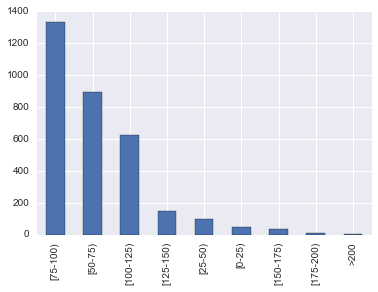

In [45]:
data.weight[data.weight != '?'].value_counts().plot(kind = 'bar')

In [35]:
data.diag_1.value_counts().sort_values(ascending = False)

428       6862
414       6581
786       4016
410       3614
486       3508
427       2766
491       2275
715       2151
682       2042
434       2028
780       2019
996       1967
276       1889
38        1688
250.8     1680
599       1595
584       1520
V57       1207
250.6     1183
518       1115
820       1082
577       1057
493       1056
435       1016
562        989
574        965
296        896
560        876
250.7      871
250.13     851
          ... 
637          1
976          1
698          1
671          1
381          1
543          1
994          1
684          1
325          1
791          1
84           1
391          1
207          1
827          1
690          1
915          1
219          1
57           1
314          1
372          1
E909         1
412          1
939          1
389          1
640          1
704          1
V60          1
97           1
839          1
373          1
Name: diag_1, dtype: int64

### That said, weight has a value in 3197 occurences, so maybe just use them as a subset

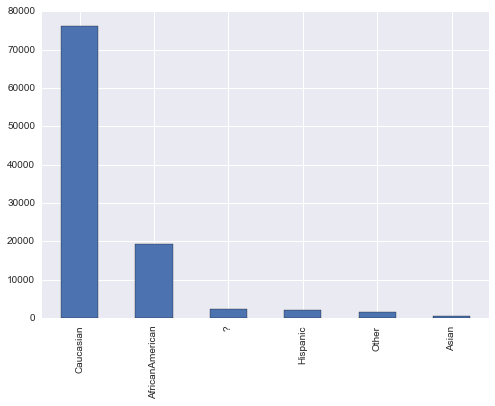

In [81]:
data['race'].value_counts().plot(kind = 'bar')

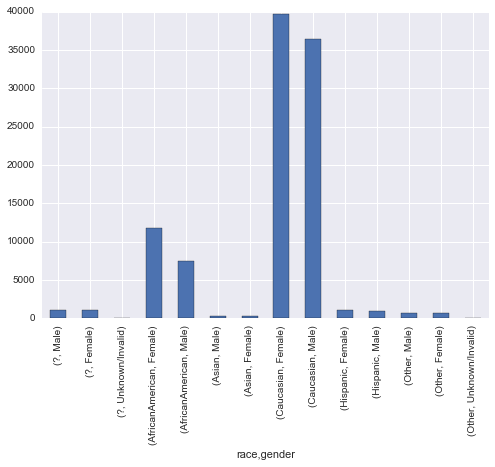

In [6]:
data.groupby(data.race)['gender'].value_counts().plot(kind = 'bar')

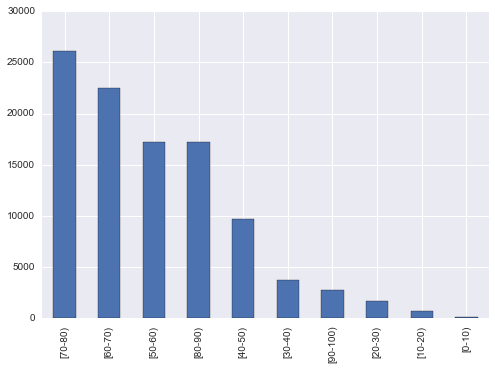

In [83]:
data['age'].value_counts().plot(kind = 'bar')

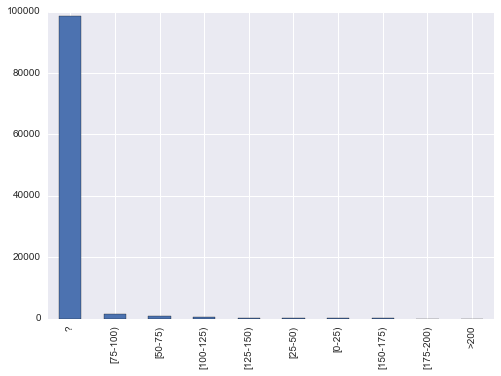

In [112]:
data['weight'].value_counts().plot(kind = 'bar')

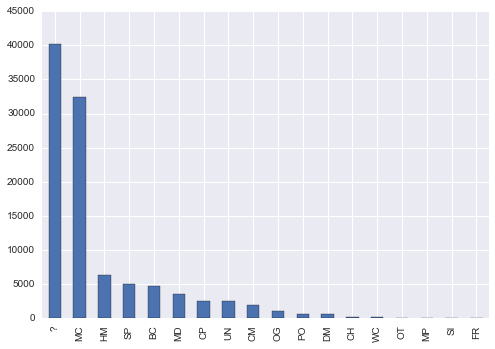

In [85]:
data['payer_code'].value_counts().plot(kind = 'bar')

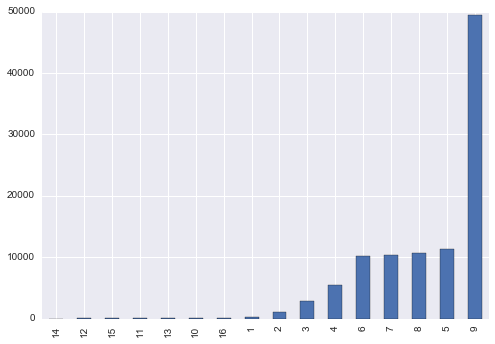

In [92]:
data['number_diagnoses'].value_counts().sort_values().plot(kind = 'bar')

In [29]:
data['diag_3'].value_counts().head(30).sum()

67286

### HAD THE DIAGNOSIS CODES, BUT WANTED THE DIAGNOSIS NAMES

Based on the year of the data collection, I assumed they were using ICD-9 codes (instead of the newer ICD-10).  I used http://www.icd10codesearch.com/? to search those top 30 diagnosis codes and return a shortened best match for each of the 78 unique codes (12 were duplicated across the 3 diagnosis categories).

The data contains 101,766 records.  Using
- data['diag_1'].value_counts().head(30)
- data['diag_2'].value_counts().head(30)
- data['diag_3'].value_counts().head(30)

I found that the top 30 diagnoses for:
- diag_1 includes 61,365 records
- diag_2 includes 68,574 records
- diag_3 includes 67,286 records

After using each of these 78 diagnosis codes to make a new column with the diagnosis name, I was able to label xxx records

In [36]:
diagnosis_name = {
    '250.13' : 'diabetes with ketoacidosis type 1',
    '250.6' : 'diabetes with neuropathy',
    '250.7' : 'diabetes with peripheral circulatory disorder',
    '250.8' : 'diabetes without complication',
    '276' : 'hyperosmolarity and or hypernatremia',
    '296' : 'bipolar disorder',
    '38' : 'septicemia',
    '410' : 'acute myocardial infarction',
    '414' : 'coronary atherosclerosis',
    '427' : 'paroxysmal supraventricular tachycardia',
    '428' : 'congestive heart failure',
    '434' : 'cerebral thrombosis without infarction',
    '435' : 'basilar artery syndrome',
    '486' : 'pneumonia',
    '491' : 'chronic bronchitis',
    '493' : 'asthma',
    '518' : 'pulmonary collapse',
    '560' : 'intussusception',
    '562' : 'diverticulosis',
    '574' : 'acute cholecystitis',
    '577' : 'acute pancreatitis',
    '584' : 'acute kidney failure',
    '599' : 'urinary tract infection',
    '682' : 'cellulitis and abscess',
    '715' : 'osteoarthrosis',
    '780' : 'coma',
    '786' : 'respiratory abnormality',
    '820' : 'fracture of femur',
    '996' : 'cardiac device complications',
    'V57' : 'physical therapy',
    '276' : 'hyperosmolarity and or hypernatremia',
    '428' : 'congestive heart failure',
    '41' : 'streptococcus infection',
    '427' : 'paroxysmal supraventricular tachycardia',
    '250' : 'diabetes without complication',
    '599' : 'urinary tract infection',
    '250.01' : 'diabetes type 1 without complication',
    '414' : 'coronary atherosclerosis',
    '250.02' : 'diabetes type 2 without complication',
    '272' : 'pure hypercholesterolemia',
    '584' : 'acute kidney failure',
    '491' : 'chronic bronchitis',
    '278' : 'obesity',
    '280' : 'iron deficiency anemia',
    '780' : 'coma',
    '285' : 'sideroblastic anemia',
    '682' : 'cellulitis and abscess',
    '486' : 'pneumonia',
    '518' : 'pulmonary collapse',
    '305' : 'nondependent alcohol abuse',
    '250.6' : 'diabetes with neuropathy',
    '493' : 'asthma',
    '786' : 'respiratory abnormality',
    '401' : 'malignant essential hypertension',
    '403' : 'hypertensive chronic kidney disease',
    '276' : 'hyperosmolarity and or hypernatremia',
    '428' : 'congestive heart failure',
    '427' : 'paroxysmal supraventricular tachycardia',
    '414' : 'coronary atherosclerosis',
    '411' : 'postmyocardial infarction syndrome',
    '413' : 'angina decubitus',
    '424' : 'mitral valve disorders',
    '599' : 'urinary tract infection',
    '425' : 'endomyocardial fibrosis',
    '496' : 'chronic obstructive pulmonary disease',
    '780' : 'coma',
    '530' : 'esophagitis',
    '585' : 'chronic kidney disease',
    '250.6' : 'diabetes with neuropathy',
    '584' : 'acute kidney failure',
    '707' : 'pressure ulcer',
    '682' : 'cellulitis and abscess',
    '518' : 'pulmonary collapse',
    '998' : 'postoperative shock',
    '493' : 'asthma',
    '?' : 'unknown',
    'V45' : 'post-surgical state cardiac device',
    '786' : 'respiratory abnormality'
}

In [44]:
for x in data.diag_1:
    try x.replace(lambda x: change_diagnosis_name(x)


def change_diagnosis_name(x):
    x = str(x)
    if x.apply(lambda x: diagnosis_name[x]) == :
        return 'Unknown'
    else: 
        x.apply(lambda x: diagnosis_name[x])

data['diag1_name'] = data['diag_1'].apply(lambda x: change_diagnosis_name(x))
                                    
data['diag1_name'].head()

AttributeError: 'str' object has no attribute 'apply'

In [ ]:
'admission_type_id', 'admission_source_id', 'medical_specialty', 'time_in_hospital', 'discharge_disposition_id', 
'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 

### That said, payer_code == ? is still 40,256 occurences, so maybe just use them as a subset

In [34]:
data[data.payer_code == '?'].count()

race                        40256
gender                      40256
age                         40256
weight                      40256
admission_type_id           40256
discharge_disposition_id    40256
admission_source_id         40256
time_in_hospital            40256
payer_code                  40256
medical_specialty           40256
num_lab_procedures          40256
num_procedures              40256
num_medications             40256
number_outpatient           40256
number_emergency            40256
number_inpatient            40256
diag_1                      40256
diag_2                      40256
diag_3                      40256
number_diagnoses            40256
max_glu_serum               40256
a1c                         40256
metformin                   40256
repaglinide                 40256
nateglinide                 40256
chlorpropamide              40256
glimepiride                 40256
acetohexamide               40256
glipizide                   40256
glyburide     

### Replace values to their categorical values

In [100]:
to_replace_age = {
    '[0-10)' : '0 to 10',
    '[10-20)' : '10 to 20',
    '[20-30)' : '20 to 30',
    '[30-40)' : '30 to 40',
    '[40-50)' : '40 to 50',
    '[50-60)' : '50 to 60',
    '[60-70)' : '60 to 70',
    '[70-80)' : '70 to 80',
    '[80-90)' : '80 to 90',
    '[90-100)' : '90 to 100'
}

to_replace_weight = {
    '[0-10)' : '0 to 25',
    '[10-20)': '25 to 50',
    '[20-30)': '50 to 75',
    '[30-40)': '75 to 100',
    '[40-50)': '100 to 125',
    '[50-60)': '125 to 150',
    '[60-70)': '150 to 175',
    '[70-80)': '175 to 200',
    '[80-90)': 'over 200'
}

to_replace_admission_type_id = {
    1 : 'emergency',
    2 : 'urgent',
    3 : 'elective',
    4 : 'newborn',
    5 : 'not available',
    6 : 'NULL',
    7 : 'trauma center',
    8 : 'not mapped'
}

to_replace_discharge_disposition_id = {
    1 : 'home',
    2 : 'short term hospital',
    3 : 'SNF',
    4 : 'ICF',
    5 : 'inpatient care institution',
    6 : 'home with home health service',
    7 : 'Left AMA',
    8 : 'home under care of home IV provider',
    9 : 'admitted to this hospital',
    10 : 'neonate to another neonate hospital',
    11 : 'expired',
    12 : 'still patient or expected to return for outpatient',
    13 : 'hospice at home',
    14 : 'hospice at medical facility',
    15 : 'this institution for medicare approved swing bed',
    16 : 'another institution for outpatient services',
    17 : 'this institution for outpatient services',
    18 : 'NULL',
    19 : 'expired at home. Medicaid only, hospice',
    20 : 'expired at medical facility. Medicaid only, hospice',
    21 : 'expired at unknown place. Medicaid only, hospice',
    22 : 'rehab facility',
    23 : 'long term care hospital',
    24 : 'SNF under medicaid, but not medicare',
    25 : 'not mapped',
    26 : 'another health care facility, undefined',
    27 : 'federal health care facility',
    28 : 'psychiatric hospital',
    29 : 'critical care access hospital'
}

to_replace_admission_source_id = {
    1 : 'MD',
    2 : 'clinic',
    3 : 'HMO',
    4 : 'hospital',
    5 : 'SNF',
    6 : 'another health care facility',
    7 : 'ED',
    8 : 'court or law enforcement',
    9 : 'not available',
    10 : 'critical access hospital',
    11 : 'normal delivery',
    12 : 'premature delivery',
    13 : 'sick baby',
    14 : 'extramural birth',
    15 : 'not available',
    16 : 'not listed',
    17 : 'NULL',
    18 : 'home health agency - transfer from another',
    19 : 'home health agency - readmission to same',
    20 : 'not mapped',
    21 : 'unknown',
    22 : 'hospital, now a different claim',
    23 : 'born in this hospital',
    24 : 'born in other hospital',
    25 : 'transfer from outpatient surgery center',
    26 : 'hospice'
}

# TO ACTUALLY DO THE CHANGES

# age
data['age'] = data['age'].apply(lambda x:to_replace_age[x])
# weight
data['weight'] = data['weight'].apply(lambda x:to_replace_weight[x])
# admission_type_id
data['admission_type_id'] = data['admission_type_id'].apply(lambda x:to_replace_admission_type_id[x])
# discharge_disposition_id
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x:to_replace_discharge_disposition_id[x])
# admission_source_id
data['admission_source_id'] = data['admission_source_id'].apply(lambda x:to_replace_admission_source_id[x])

KeyError: '0 to 10'

In [101]:
data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetes_med,readmitted
0,Caucasian,Female,0 to 10,?,6,25,1,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,10 to 20,?,1,1,7,3,?,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,20 to 30,?,1,1,7,2,?,?,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,30 to 40,?,1,1,7,2,?,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,40 to 50,?,1,1,7,1,?,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# SOME NOTES

### Will need to clean columns
- drop encounter_id
- drop patient_nbr
- age saved as a list, should be a category
- n/a for weight == '?'
- change codes to category names for
- - admission_type_id	
- - discharge_disposition_id
- - admission_source_id
- - time_in_hospital (units?)
- - diag_1, 2, 3

### CLASSIFY based on 
- demographics
- - race, gender, age, weight, payor code, A1c

- meds
- - various meds Y/N
- - count of meds not no
- - classify med types (oral, inject) and y/n
- - insulin changes

- utilization
- - admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital
- - previous :: number_outpatient, number_emergency, number_inpatient
- - num_lab_procedures, num_procedures, num_medications, number_diagnoses

### PREDICT :: READMISSION == NO | < 30 | > 30 